In [1]:
from NNModel import MultiLayerNN
import numpy as np
import pickle
import torch
import torch.nn as nn
from prep_data import prep_data
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [14]:
train_loader, test_loader = prep_data()
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
state_dict = torch.load("../data/model.pt", weights_only=True)
new_dict = {}
#When model compiles, all weights are modified from LAYERNAME to _orig_model.LAYERNAME. We remove the _orig_model. for compatibility
for k in state_dict.keys():
    new_dict[k[10:]] = state_dict[k]
model = MultiLayerNN(latent_size=128, num_layers=3)
model.load_state_dict(new_dict)
model.to(device)
images = []
labels = []
for loader in [train_loader, test_loader]:
    for image, label in loader:
        images.append(image.squeeze().reshape(-1, 28*28))
        labels.append(label)
images = torch.cat(images).to(device)
labels = torch.cat(labels).to(device)

In [23]:
# Dictionary to store the activations
activations = {}
# Dictionary to store layer names for plotting titles
layer_names = {}

def get_activation(name):
    """Hook function to save the output of a layer"""
    def hook(model, input, output):
        # We detach the output tensor to prevent saving the whole computation graph
        activations[name] = output.detach()
    return hook

# Register a forward hook for each linear layer
# We capture the output of the Linear layer *before* it goes into ReLU
hook_handles = []
layer_id = 0

# Hook for the first linear layer
layer_name = f"Layer {layer_id}: Dim Reduction"
handle = model.dim_reduction.register_forward_hook(get_activation(layer_name))
hook_handles.append(handle)
layer_names[layer_id] = layer_name
layer_id += 1

# Hooks for the hidden linear layers
for i, layer in enumerate(model.hidden_layers):
    if isinstance(layer, nn.Linear):
        layer_name = f"Layer {layer_id}: Hidden Linear"
        handle = layer.register_forward_hook(get_activation(layer_name))
        hook_handles.append(handle)
        layer_names[layer_id] = layer_name
        layer_id += 1
layer_name = f"Layer {layer_id}: Output"
handle = model.output.register_forward_hook(get_activation(layer_name))
hook_handles.append(handle)
layer_names[layer_id] = layer_name

# Run a forward pass to trigger the hooks and populate the 'activations' dict
with torch.no_grad():
    output = model(images)

# Don't forget to remove the hooks when you're done to avoid memory leaks
for handle in hook_handles:
    handle.remove()

Generating boundary for: Layer 0: Dim Reduction


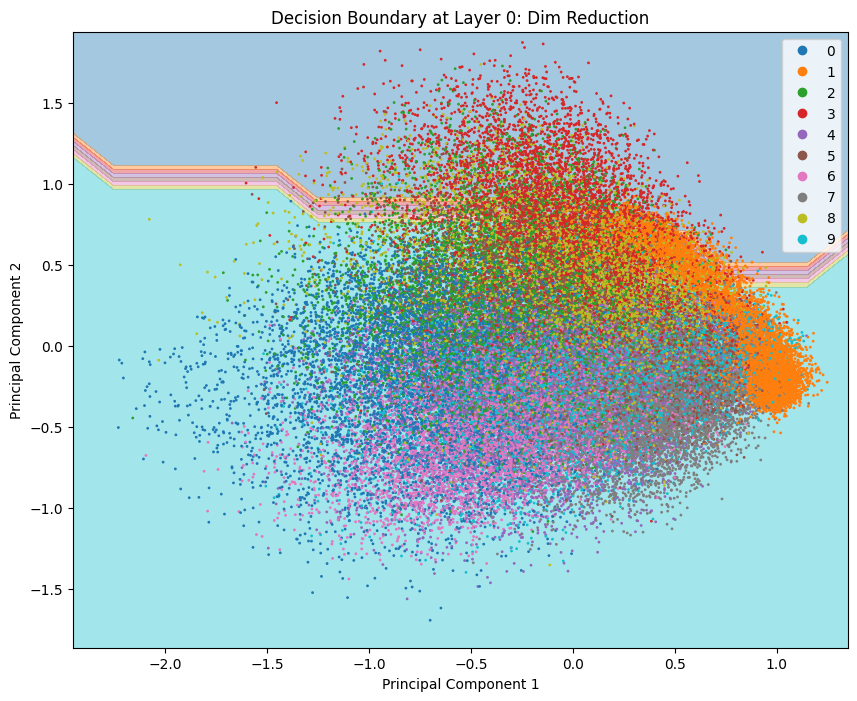

Generating boundary for: Layer 1: Hidden Linear


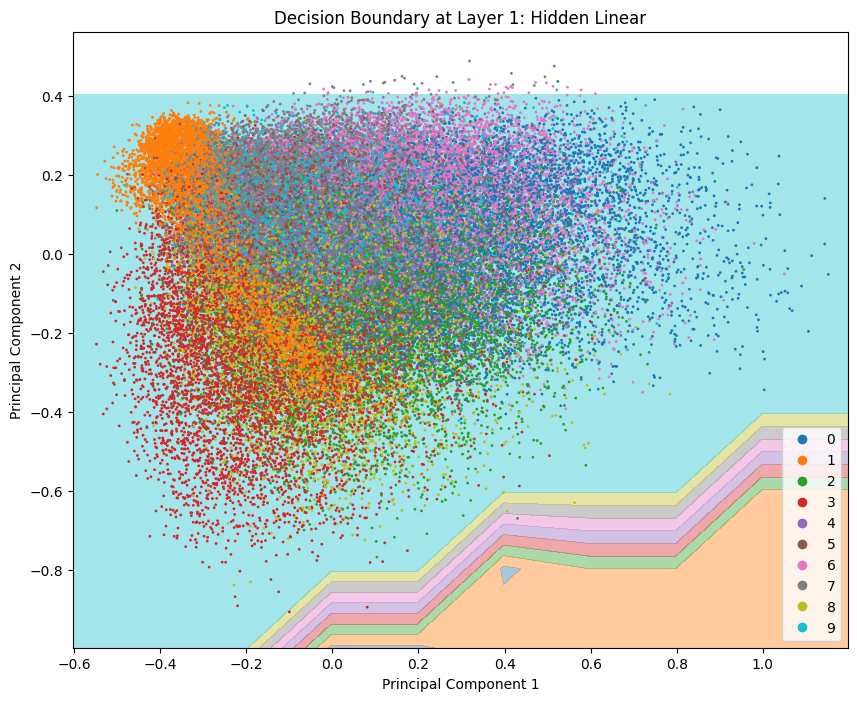

Generating boundary for: Layer 2: Hidden Linear


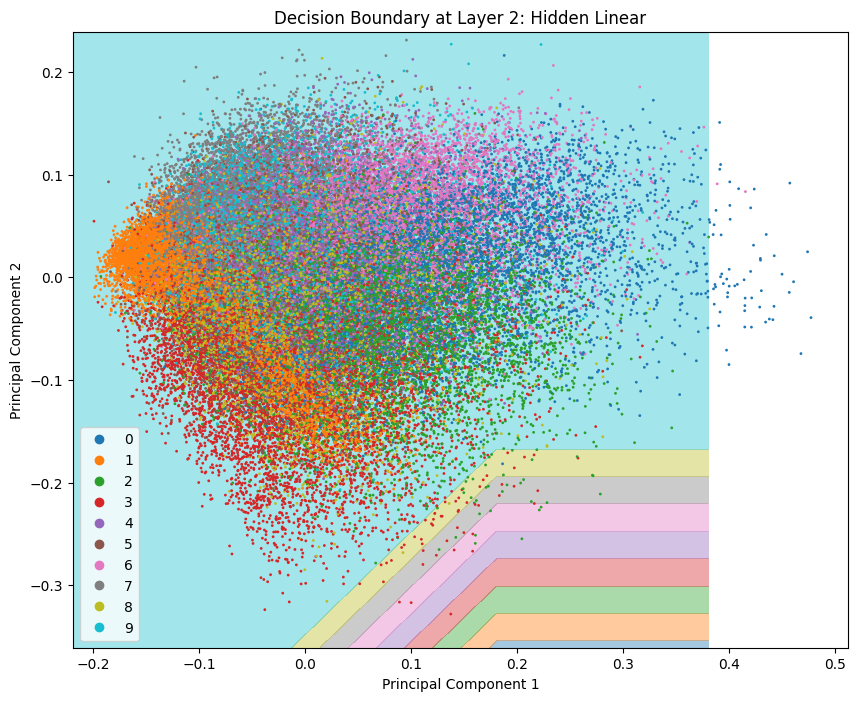

Generating boundary for: Layer 3: Hidden Linear


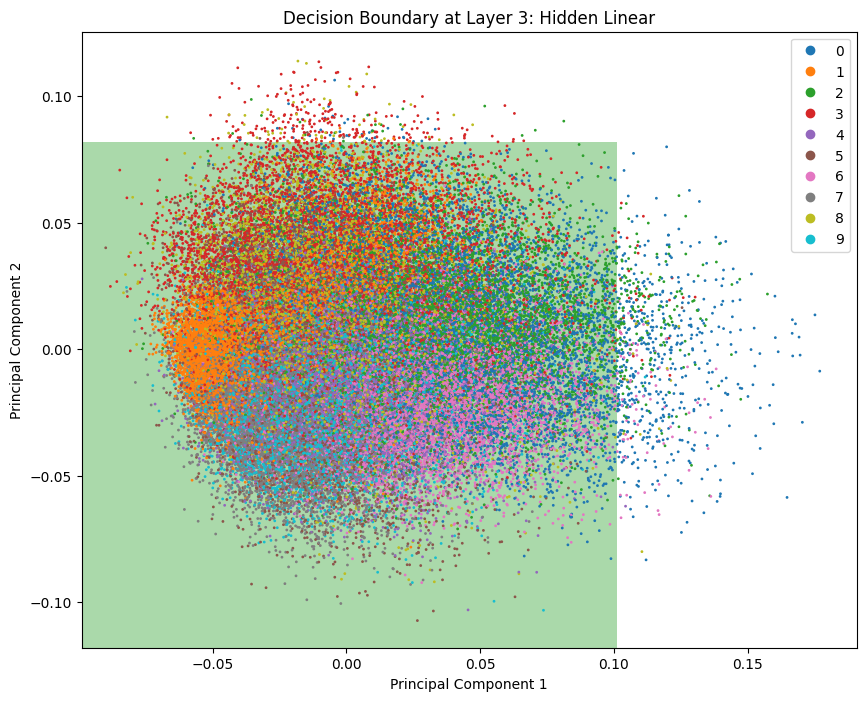

Generating boundary for: Layer 4: Output


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (1, 1)

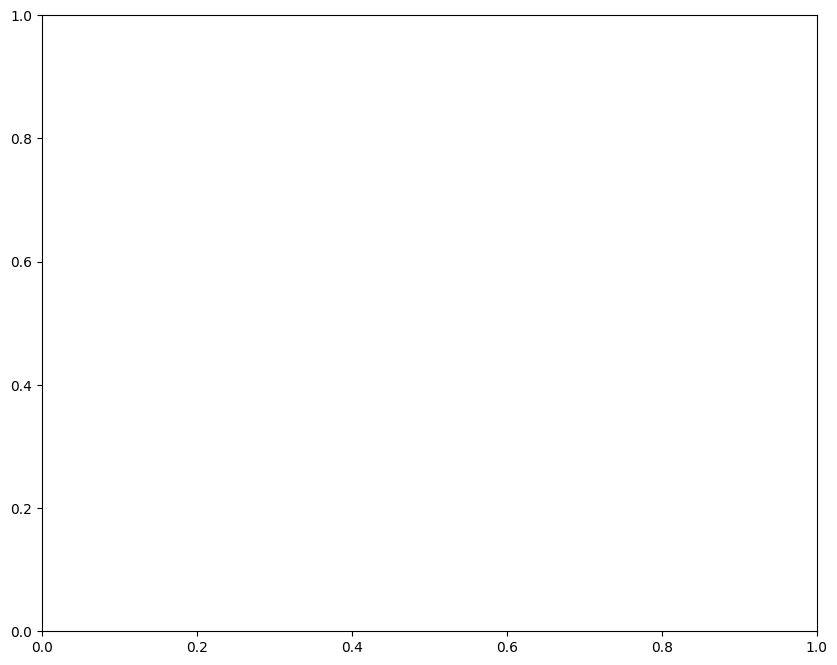

In [33]:
def predict_from_layer(start_layer_index, activation_tensor):
    """
    Takes an activation tensor from a specific layer and passes it
    through the rest of the model to get a final prediction.
    """
    x = activation_tensor

    # Manually apply the forward pass for subsequent layers
    # Apply ReLU for the starting layer (since we hooked pre-relu)
    x = nn.functional.relu(x)

    # Find the starting point in the hidden_layers list
    linear_layer_count = 1 # Start after dim_reduction
    start_idx_in_hidden = -1
    for i, layer in enumerate(model.hidden_layers):
        if isinstance(layer, nn.Linear):
            if linear_layer_count == start_layer_index:
                start_idx_in_hidden = i + 1 # Start from the ReLU after this linear layer
                break
            linear_layer_count += 1

    # Pass through remaining hidden layers
    if start_idx_in_hidden != -1:
        for i in range(start_idx_in_hidden, len(model.hidden_layers)):
            x = model.hidden_layers[i](x)

    # Final output layer
    if x.shape[1] == 10:
        return x
    return model.output(x)


# Now, loop through the captured activations and plot
for layer_index, (name, data) in enumerate(activations.items()):
    print(f"Generating boundary for: {name}")

    # 1. Fit PCA on this layer's activations
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(data.cpu().numpy())

    # 2. Create mesh grid
    x_min, x_max = features_2d[:, 0].min()*1.1, features_2d[:, 0].max() *1.1
    y_min, y_max = features_2d[:, 1].min() *1.1, features_2d[:, 1].max() *1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))

    # 3. Inverse transform grid points and predict
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_high_dim = pca.inverse_transform(grid_points)
    grid_tensor = torch.tensor(grid_points_high_dim, dtype=torch.float32).to(device)

    with torch.no_grad():
        # Use the helper function to predict from this intermediate layer
        outputs = predict_from_layer(layer_index, grid_tensor)
        _, Z = torch.max(outputs, 1)
        Z = Z.cpu().numpy().reshape(xx.shape)

    # 4. Plotting
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.tab10)
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels.cpu(), s=1, cmap=plt.cm.tab10)

    plt.title(f"Decision Boundary at {name}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(handles=scatter.legend_elements()[0], labels=list(range(10)))
    plt.show()